<h1><center>
Rover project <br></center></h1>
<h4><center>
Roberto Lucchesi - 1744941 </center></h4>


<h2><center>Introduction</center></h2>

NASA’s Mars Curiosity Rover is a mobile robot that is exploring the Gale Crater on Mars to search areas of the red planet for past or present conditions favorable for life.<br>
The following data of the rover should be considered:

- Maximum velocity of the rover: $V_{max} = 0.04$ m/s <br>
- Wheel base: L = 3 m

All the code here presented has been developed in Python within a Jupyter Notebook. Data provided in `.mat` has been converted to `.csv` and loaded into the program. This Python program makes use of `numpy` and `matplotlib` to replicate MATLAB functionalities.


We begin by importing all needed modules to run the script. The custom imports that are specific to one task are marked with comments, otherwise assume that the import is used throughout the code. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# custom modules
from graph import *
from AStar import * # code for path planning task
from grid import *
from traj_gen import * # code for navigation task
from rover import *
from utils import *
from localization import * # code for localization task

For the operative ground, a 45x30 km map is provided in greyscale, with a resolution of 10m. Inaccessible regions are identified with a `255` (white) boundary margin.  
We load the data provided:

<center>
  
 `mars_map` contains the grayscale operative map. <br>
 `obstacle_map` containst the obstacle boundaries <br>
   `pos_lm` contains all landmark positions <br>

</center>

We also initialize all points of interest: <br>


&#128309; $P_0$ = (42.38, 11.59) km  <br>
&#128308; $P_1$ = (33.07, 19.01) km  <br>
&#128994; $P_2$  = (38.80, 25.00) km 


At last, we initialize a `Grid` object with the map, obstacles and landamarks provided. This class is responsible to do boundary checking and plotting. 

<div class="alert alert-block alert-warning">
<b>Attention:</b> Due to the data files being too large for Github, they are not provided on the main repo.
</div>

In [3]:
dataFolder = "data/"

## Constants of the problem
maxVel = 0.04; # [m/s] maximum velocity of the rover 
LAxis = 3; # [m] length of the rover wheel axis

# Points of interest
P0 = (42.38*10**3, 11.59*10**3)
P1 = (33.07*10**3, 19.01*10**3)
P2 = (38.80*10**3, 25.00*10**3)

### load data from csv file
# landmarks coordinates
Xlm = np.loadtxt(dataFolder +"Xlm.csv")
Ylm = np.loadtxt(dataFolder +"Ylm.csv")
pos_lm = np.array([Xlm, Ylm]).T # landmark positions

# map and obstacle map
mars_map = np.loadtxt(dataFolder +"map.csv", delimiter=",")
obstacle_map = np.loadtxt(dataFolder +"obstacle.csv", delimiter=",")

sup_map = map_obstacle(mars_map, obstacle_map)

# Create mars_grid (45kmx30km, 10m resolution)
mars_grid = Grid(xlim = 45000, ylim = 30000, res = 10, 
            image = sup_map, obstacle = obstacle_map, 
            landmarks = pos_lm, corner = 'll') 

We print the map, with the points of interests and all landmarks. The steep regions are evidentiated with a white contour.

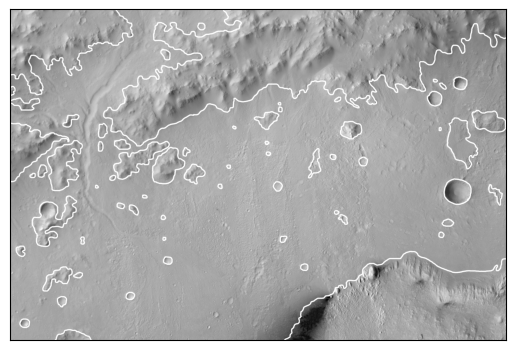

In [4]:
mars_grid.plot()

<h2><center> Task 1: Navigation </center></h2> 

The first task requires the determination of the trajectory from &#128309; $P_0$ to &#128308; $P_1$. We also need to arrive at the target with an heading $\theta_f$  = 180, while we start with an heading of $\theta_0$ = 90. The heading angle is measured by considering positive an anti-clockwise rotation from the __x__-axis (i.e. $\theta_0$ is parallel to the North direction.)  


For this problem then our state is going to be represented with a 3x1 vector:



<center>

__q__ = $\begin{bmatrix} x \\ y \\ \theta \end{bmatrix}$ and    $\dot{q}$ =  $\begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \end{bmatrix}$

</center>



We first run the __A*__ algorithm to have an idea on how much does it cost the minimum expensive path from $P_0$ to $P_1$, plotting the result on the map.

In [5]:
# A* algorithm from P0 to P1
path, gScore = AStar(mars_grid, P0, P1) 
np_path = np.array(path)
print("A* cost: ", gScore)
# Plot the path


A* cost:  12383.46463280844


To achieve a realizable trajectory we employ the <b>Moving to a pose</b> control scheme, implemented in the `control_pose` function.  

The values here used for $k_\rho$, $k_\alpha$, and $k_\beta$ are handpicked to achieve the requisite of not entering the forbidden regions marked on the map.

In [6]:
# Find trajectory via manual tuning of control_pose gains

Curiosity_rover = Rover(maxVel, LAxis)

np_P0 = np.array([P0[0],P0[1], np.deg2rad(90)])
np_P1 = np.array([P1[0],P1[1], np.deg2rad(180)])

q, qd, t  = control_pose(Curiosity_rover, np_P0, np_P1, 1, 
                         k_rho=0.04, k_alpha=0.09, k_beta=-0.115)


cost_traj = cost_path(q[:,0:2])


theta_plot =  list_np_angle(q[:,2])
theta_dot_plot = np.unwrap(qd[:,2])
print("Theta_final: ",theta_plot[-1])
print("Cost: ", cost_traj)
print("Time of trajectory: " + str(t) + " s")
print("Time in sol: ", t/sol_in_secs)



Stable: k_rho, k_alpha, k_beta = (0.04, 0.09, -0.115)
Theta_final:  179.9999779726177
Cost:  13244.482120523948
Time of trajectory: 331147 s
Time in sol:  3.7301727883970917


The control scheme requires
\begin{cases}
    k_\rho > 0 \\
    k_\beta < 0 \\
    k_\alpha - k\rho > 0
\end{cases}
The values chosen for [$k_\rho$, $k_\alpha$, $k_\beta$] are [0.04, 0.09, -0.115].
The values chose of [$k_\rho$, $k_\alpha$, $k_\rho$] = [0.04, ]

In [7]:

### - 1.1) Plot the trajectory of the rover in the map from 
###        P0 = (42.38, 11.59)km to P1 = (33.07,19.01)km

# Create submap around midpoint between P0 and P1
x_mid, y_mid = (P0[0]+P1[0])/2, (P0[1]+P1[1])/2

x_start, x_end = x_mid - 5000, x_mid + 5000
y_start, y_end = y_mid - 4000, y_mid + 4000

# Create submap
submap = mars_grid.get_submap(x_start, x_end, y_start, y_end)
submap.plot()



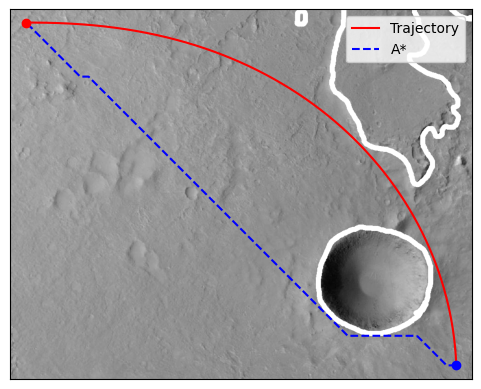

In [8]:
from IPython.display import display, HTML
display(HTML('<div class="text-center">'))


plt.plot(q[:,0]/10 - x_start/10, q[:,1]/10-y_start/10, 'r')

plt.plot(np_path[:,0]/10 - x_start/10, np_path[:,1]/10-y_start/10, 'b', linestyle='--')
plt.plot(P0[0]/10 - x_start/10, P0[1]/10-y_start/10, 'bo')
plt.plot(P1[0]/10 - x_start/10, P1[1]/10-y_start/10, 'ro')
plt.legend(['Trajectory', 'A*'])

plt.show()
display(HTML('</div>'))


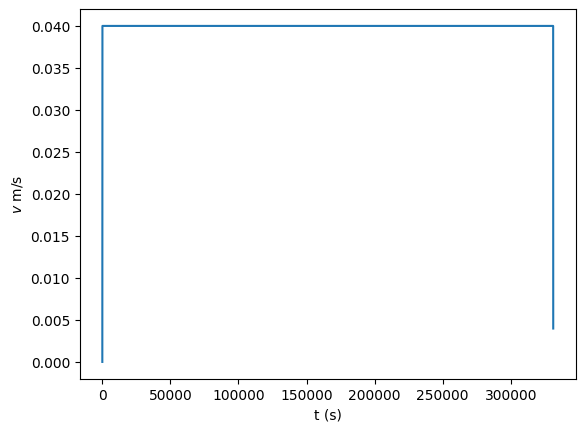

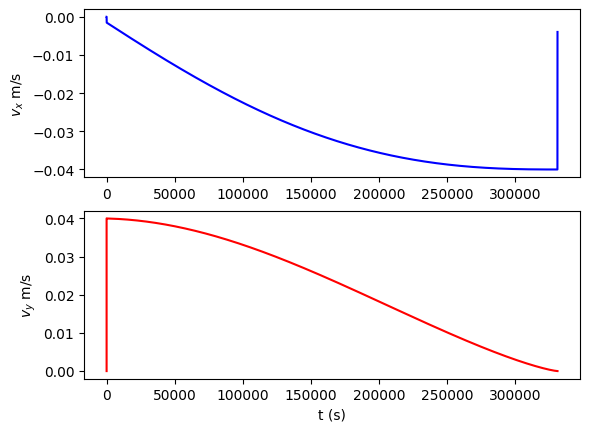

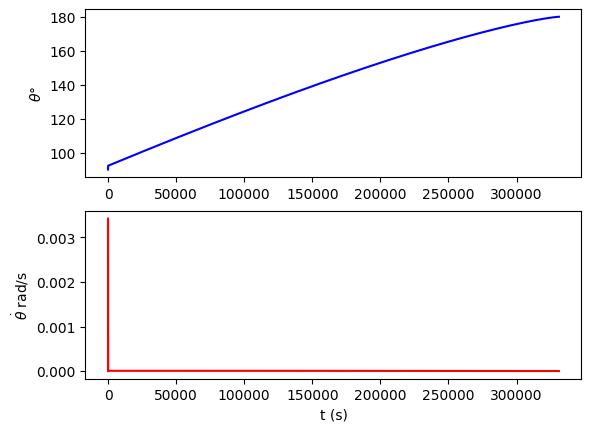

In [9]:

### 1.2) Plot the velocity profile of the rover
# plot velocity module
plt.figure()
plt.plot(np.sqrt(qd[:,0]**2 + qd[:,1]**2))
plt.ylabel(r'$v$' + " m/s")
plt.xlabel("t (s)")

# plot velocity components
plt.figure()
plt.subplot(2,1,1)
plt.ylabel(r'$v_x$' + " m/s")
plt.plot(qd[:,0], 'b-')
plt.subplot(2,1,2)
plt.ylabel(r'$v_y$' + " m/s")
plt.xlabel("t (s)")
plt.plot(qd[:,1], 'r-')

### 1.3) Plot the steering angle profile of the rover
plt.figure()
plt.subplot(2,1,1)
plt.ylabel(r'$\theta$' + "°")
plt.plot(theta_plot, 'b-')

### 1.4) Plot the rate of change of the steering angle profile of the rover
plt.subplot(2,1,2)
plt.ylabel(r'$\dot{\theta}$' + " rad/s")
plt.xlabel("t (s)")
plt.plot(theta_dot_plot, 'r-')
plt.show()





# Task 2

In [10]:
### TASK 2 ### -- 3min average runtime
# Go from P1 to P2

# Run A* from P0 to P1

# P2 = (10.87*10**3, 25.67*10**3)

# path2, gScore2 = AStar(mars_grid, P1, P2) # Run A* from P1 to P2
# np_path2 = np.array(path2)



In [11]:
# ## Plot TASK 2
# # Plot path
# plt.plot(np_path[:,0]/10, np_path[:,1]/10, 'b')
# plt.plot(np_path2[:,0]/10, np_path2[:,1]/10, 'r')

# mars_grid.plot()
# plt.plot(P0[0]/10, P0[1]/10, 'bo')
# plt.plot(P1[0]/10, P1[1]/10, 'ro')
# plt.plot(P2[0]/10, P2[1]/10, 'go')

# plt.text(P0[0]/10, P0[1]/10+50, 'P0', color='blue', fontsize=12)
# plt.text(P1[0]/10, P1[1]/10+70, 'P1', color='red', fontsize=12)
# plt.text(P2[0]/10, P2[1]/10+70, 'P2', color='green', fontsize=12)

# plt.show()
# print("Cost from P0 to P1: ", gScore)
# print("Cost from P1 to P2: ", gScore2)
# print("Total cost: ", gScore + gScore2)


# Task 3

In [12]:
### TASK 3 ### 

## Dead reckoning with odomoter only
# We have a trajectory q integrated each 1s, and the odometer has
# a frequency of 1hz, so we're good

r_traj = q # trajectory of the rover

# Stdev on initial rover position
sigma_x = 6 # [m] standard deviation of the rover position
sigma_y = 6 # [m] *standard deviation of the rover position
sigma_theta = np.deg2rad(1) # [rad] standard deviation of the rover orientation

# odometer noise 
sigma_d  = 4*10**(-3) # [m] standard deviation of the distance measurement
sigma_phi = np.deg2rad(0.05) # [rad] standard deviation of the angle measurement

p0 = np.eye(3)*[sigma_x**2, sigma_y**2, sigma_theta**2] # initial covariance matrix


dr_traj, dr_p = dead_recon(r_traj, p0, sigma_d, sigma_phi)

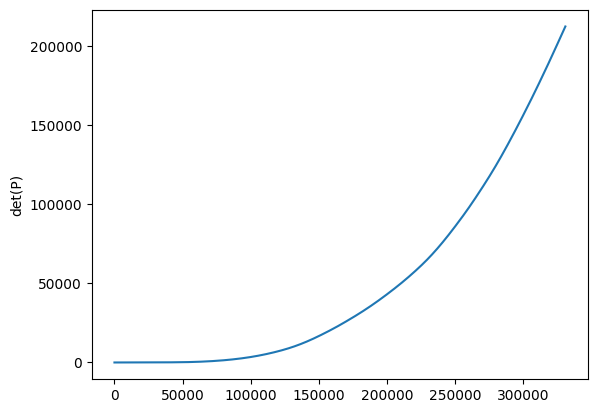

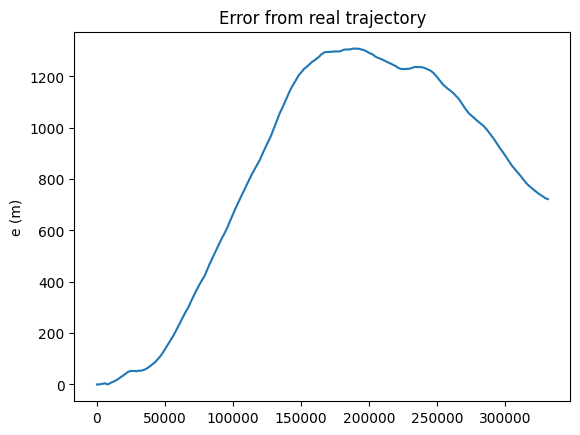

In [13]:
plt.figure()
plt.ylabel("det(P)")
det_p = np.zeros(len(dr_p))
for i in range(len(dr_p)):
    det_p[i] = np.sqrt(np.linalg.det(dr_p[i]))
plt.plot(det_p)

# Plot error from real trajectory
plt.figure()
plt.title("Error from real trajectory")
plt.ylabel("e (m)")
plt.plot(np.sqrt((dr_traj[:,0] - r_traj[:,0])**2 + (dr_traj[:,1] - r_traj[:,1])**2))

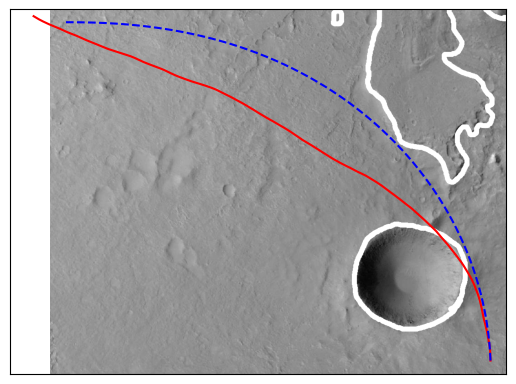

In [14]:
submap.plot()
# Plot real trajectory 

plt.plot(dr_traj[:,0]/10 - submap.x_off/10, dr_traj[:,1]/10 - submap.y_off/10, 'r')
plt.plot(r_traj[:,0]/10 - submap.x_off/10, r_traj[:,1]/10 - submap.y_off/10, 'b--')
# Plot 3 sigma ellipse of the rover position
plt.show()

In [15]:
# Dead reckoning with odomoter + landmark measurements
lidar_range = 500 # [m] maximum range of the lidar
sigma_rho = 0.1 # [m] standard deviation of the rho measurement
sigma_beta = np.deg2rad(0.25) # [rad] standard deviation of the beta measurement
# problematic landmark at [array([37482., 18113.])]
# first landmark at [array([41542., 15452.])] -- idx = 89663

ekf_traj, ekf_p = EKF(mars_grid, r_traj, p0, sigma_d, sigma_phi, sigma_rho, sigma_beta, lidar_range)

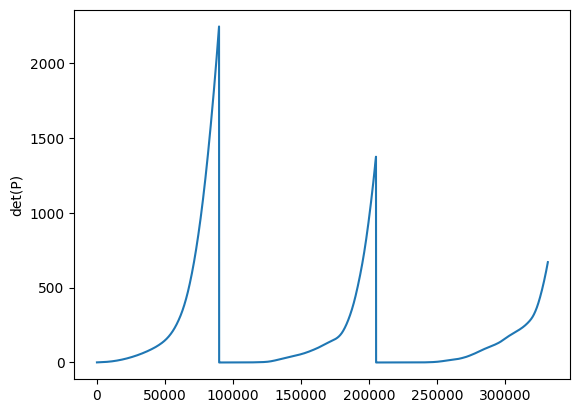

In [16]:
plt.figure()


plt.ylabel("det(P)")
det_p = np.zeros(len(ekf_p))
for i in range(len(ekf_p)):
    det_p[i] = np.sqrt(np.linalg.det(ekf_p[i]))
plt.plot(det_p)


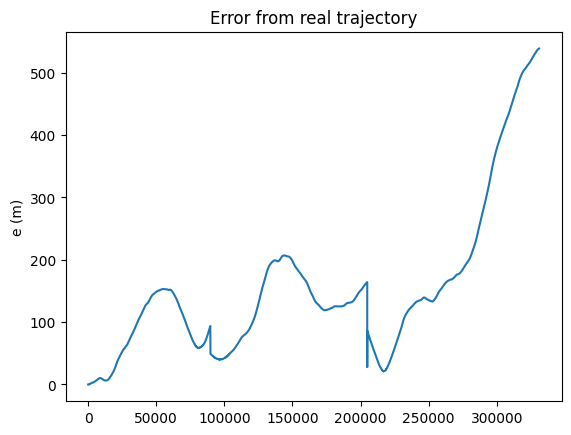

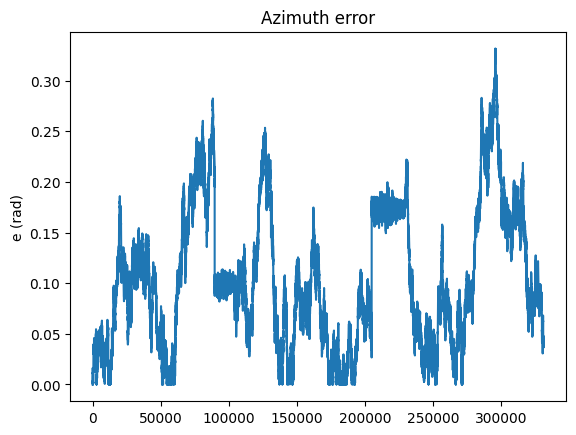

In [17]:
error = np.sqrt((ekf_traj[:,0] - r_traj[:,0])**2 + (ekf_traj[:,1] - r_traj[:,1])**2)
pose_error = np.sqrt((ekf_traj[:,2] - r_traj[:,2])**2)

# Plot error from real trajectory
plt.figure()
plt.title("Error from real trajectory")
plt.ylabel("e (m)")

plt.plot(error[:])

# pose error
plt.figure()
plt.title("Azimuth error")
plt.ylabel("e (rad)")
plt.plot(pose_error[:])
# 150000


TypeError: 'Ellipse' object is not subscriptable

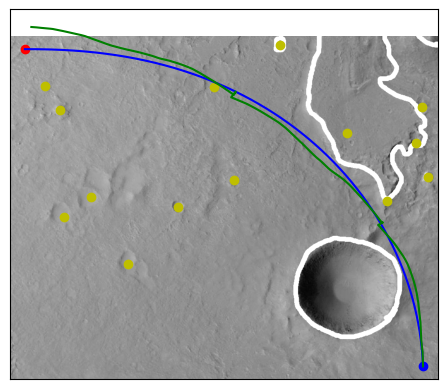

In [18]:
fig = plt.figure()
submap.plot()
for landmark in submap.landmarks:
    plt.plot(landmark[0]/10 - submap.x_off/10, landmark[1]/10 - submap.y_off/10, 'yo')
# Plot real trajectory 
plt.plot(P0[0]/10 - submap.x_off/10, P0[1]/10 - submap.y_off/10, 'bo')
plt.plot(P1[0]/10 - submap.x_off/10, P1[1]/10 - submap.y_off/10, 'ro')    

plt.plot(r_traj[:,0]/10 - submap.x_off/10, r_traj[:,1]/10 - submap.y_off/10, 'b')
plt.plot(ekf_traj[:,0]/10- submap.x_off/10, ekf_traj[:,1]/10 - submap.y_off/10, 'g')

# step in ekf_traj with a step of 1000
for i in range(0, len(ekf_traj), 1000):
    ellipse = error_ellipse(fig.gca(), ekf_traj[i,0]/10 - submap.x_off/10, ekf_traj[i,1]/10 - submap.y_off/10, ekf_p[i][0:2,0:2])
    plt.plot(ellipse[0], ellipse[1], 'g')    

plt.show()